# A Guide to A/B Testing — How to Formulate, Design and Interpret

This note follows Idil Ismiguzel's notebook [A/B Testing](https://github.com/Idilismiguzel/data_analysis/blob/main/ab_testing/AB_testing.ipynb) and the blog [A Guide to A/B Testing — How to Formulate, Design and Interpret](https://towardsdatascience.com/a-guide-to-a-b-testing-how-to-formulate-design-and-interpret-f820cc62e21a). 

To run A/B test, usually we have the following steps:
* Formulate the hypothesis
* Design the experiment
* Collect the data
* Inference/Conclusions

The content of this notebook covers two tests:

### 1. Applying statistical hypothesis test

Using statistical significance tests we can measure if the collected data shows a result more extreme than the chance might produce. If the result is beyond the chance variation, then it is statistically significant.

We first calculate test statistic as initial test statistic.

### 2. Performing permutation tests

The permutation test is one of my favorite techniques because it does not require data to be numeric or binary and sample sizes can be similar or different. Also, assumptions about normally distributed data are not needed.

Permuting means changing the order of a set of values, and what permutation test does is combining results from both groups and testing the null hypothesis by randomly drawing groups (equal to the experiment groups’ sample sizes) from the combined set and analyzing how much they differ from one another. The test repeats doing this as much as decided by the user (say 1000 times). 

In the end, user should compare the observed difference between experiment and control groups with the set of permuted differences. If the observed difference lies within the set of permuted differences, we do not reject the null hypothesis. But if the observed difference lies outside of the most permutation distribution, we reject the null hypothesis and conclude as the A/B test result (initial test statistic) is statistically significant and not due to chance.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import random
import seaborn as sns
plt.style.use("fivethirtyeight")

from scipy.stats import chi2_contingency
from scipy.stats import chi2

def perm_func(x, nA, nB):
    '''
    randomly pick up nB events among nA+nB events as the control group from 'conversion' list, and the 
    rest are in the treatment group.
    '''
    n = nA + nB
    id_B = set(random.sample(range(n), nB))
    id_A = set(range(n)) - id_B
    return x.loc[id_B].mean() - x.loc[id_A].mean()

## Example 1

Imagine that you are running a UI experiment where you want to understand the difference between conversion rates of your initial layout vs a new layout.

In this experiment, the null hypothesis assumes conversion rates are equal and if there is a difference this is only due to the chance factor. In contrast, the alternative hypothesis assumes there is a statistically significant difference between the conversion rates.

In [2]:
df_ex = {"Outcome": ["Conversion", "No Conversion"], 
         "Initial Layout": [150, 23567],
         "New Layout": [162, 23230]}

df_ex = pd.DataFrame(df_ex)

### Contingency table

In [3]:
df_ex.head()

,Outcome,Initial Layout,New Layout
0,Conversion,150,162
1,No Conversion,23567,23230


### Conversion rate for control and treatment group

In [5]:
cr_a, cr_b = 150/23717, 165/23395
print('cr_a:', cr_a, ', cr_b:', cr_b)

#Relative uplift in conversion rate = (cr_b - cr_a)/cr_a
rel_uplift = (cr_b - cr_a)/cr_a
print(rel_uplift)

cr_a: 0.006324577307416621 , cr_b: 0.007052789057490917
0.1151399871767471


### Initial Test Statistics: Chi-Squared test

In [14]:
table = np.array([[150, 165], [23717, 23395]])
stat, p, dof, expected = stats.chi2_contingency(table)
alpha = 0.05

# interpret p-value
print('significance = %.3f, p = %.3f, test statistic = -%.3f' % (alpha, p, stat))
if p <= alpha:
    print('Reject null hypothesis)')
else:
    print('Do not reject null hypothesis')

significance = 0.050, p = 0.365, test statistic = -0.822
Do not reject null hypothesis


In [12]:
# interpret test-statistic
prob = 1 - alpha
critical = stats.chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Reject null hypothesis)')
else:
    print('Do not reject null hypothesis')

probability=0.950, critical=3.841, stat=0.822
Do not reject null hypothesis


### Permutation Test

In [17]:
obs_pct_diff = 100 * (150 / 23717 - 165 / 23395)

# generate conversion list which has 46797 negative and 315 (150+165) positive events.
conversion = [0] * 46797
conversion.extend([1] * 315)
conversion = pd.Series(conversion)

In [23]:
# run 1000 permutations 
perm_diffs = [100 * perm_func(conversion, 23717, 23395) for _ in range(1000)]

In [24]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.867


This result shows us around 86% of the time we would expect to reach the experiment result by random chance. Since 
p-value > 0.05 so we cannot reject null hypothesis.

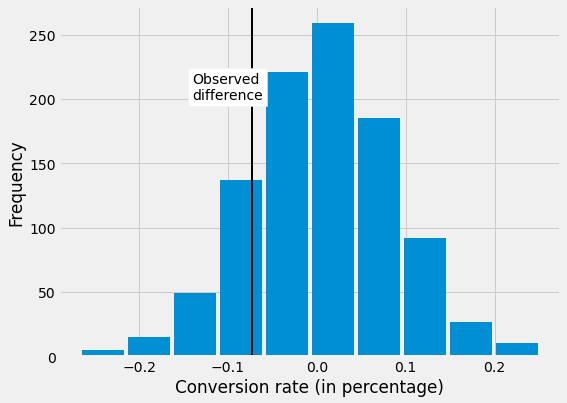

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(perm_diffs, rwidth=0.9)
ax.axvline(x=obs_pct_diff, lw=2, color="black")
ax.text(-0.14, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (in percentage)')
ax.set_ylabel('Frequency')
plt.show()

## Example 2

Imagine we are using the average session time as our metric to analyze the result of the A/B test. We aim to understand if the new design of the page gets more attention from the users and increase the time they spend on the page.

In this example will use **t-Test** (or **Student’s t-Test)** because we have **numeric data**. t-distribution is used when estimating the mean of a normally distributed population in situations where the sample size is small and the population standard deviation is unknown.

In [27]:
data = pd.read_csv("./data_Sample.csv", sep=";")
data["Time"] = data["Time"]*100

The first few rows representing different user ids look like the following:

In [28]:
data.head()

,Page,Time
0,Old design,35.0
1,New design,120.0
2,Old design,80.0
3,New design,120.0
4,Old design,150.0


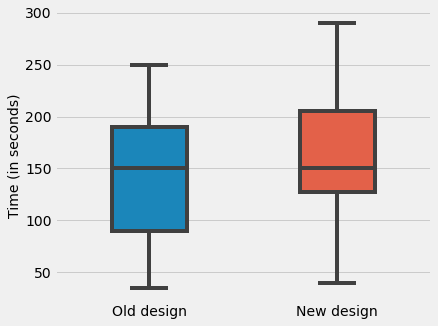

In [29]:
data["Page"] = data["Page"].apply(lambda x: str(x))
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.boxplot(x=data["Page"], y=data["Time"], width=0.4)
ax.set_ylabel('Time (in seconds)', size=14)
ax.set_xlabel("")
ax.tick_params(labelsize=14)
plt.show()

### t-test for mean difference

In [30]:
mean_cont = np.mean(data[data["Page"] == "Old design"]["Time"])
mean_exp = np.mean(data[data["Page"] == "New design"]["Time"])
mean_diff = mean_exp - mean_cont
print(f"Average difference between experiment and control samples: {mean_diff}")

test_res = stats.ttest_ind(data[data.Page ==  "Old design"]["Time"], 
                      data[data.Page == "New design"]["Time"],
                      equal_var=False)
print(f'p-value for single sided test: {test_res.pvalue / 2:.4f}')
if test_res.pvalue <= alpha:
    print('Reject null hypothesis)')
else:
    print('Do not reject null hypothesis')

Average difference between experiment and control samples: 22.857142857142833
p-value for single sided test: 0.1020
Do not reject null hypothesis


### Permutation test

In [32]:
nA = data[data.Page == 'Old design'].shape[0]
nB = data[data.Page == 'New design'].shape[0]

perm_diffs = [perm_func(data.Time, nA, nB) for _ in range(1000)]

In [33]:
larger=[i for i in perm_diffs if i > mean_exp-mean_cont]
print(len(larger)/len(perm_diffs))

0.092


As seen in the result, we do not reject the null hypothesis, meaning that the positive average difference between experiment and control samples is not significant.

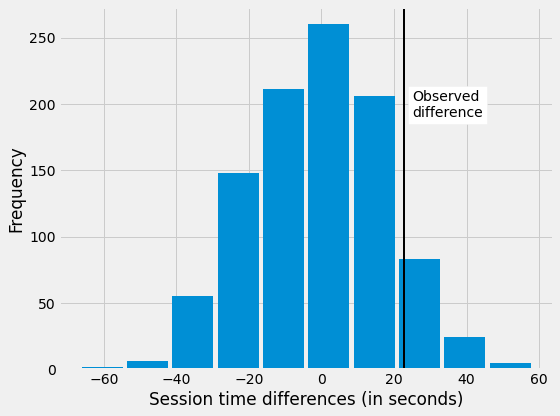

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(perm_diffs, rwidth=0.9)
ax.axvline(x = mean_exp - mean_cont, color='black', lw=2)
ax.text(25, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()